# Speasy caches levels analysis

In [3]:
import speasy as spz
amda_tree = spz.inventories.tree.amda
%matplotlib widget
# Use this instead if you are not using jupyterlab yet
#%matplotlib notebook
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import time
import numpy as np

First ensure that speasy is setup to use SciQLop cache

In [4]:
spz.config.proxy.url.set('http://sciqlop.lpp.polytechnique.fr/cache-dev')
spz.config.proxy.enabled.set(True)

In [5]:
start_time = datetime(2016,6,2)
stop_time = datetime(2016,6,8)
reference_data = spz.get_data(amda_tree.Parameters.ACE.MFI.ace_imf_all.imf, start_time, stop_time)
print(f"Data shape: {reference_data.data.shape}")
print(f"Data size in Bytes: {reference_data.data.nbytes}")

Data shape: (32400, 3)
Data size in Bytes: 777600


In [6]:
def times(f,*args, n=10,**kwargs):
    def time_once():
        start = time.perf_counter_ns()
        f(*args, **kwargs)
        stop = time.perf_counter_ns()
        return (stop - start)/1e6
    return [time_once() for _ in range(n)]

## Cache level comparison

Then request data several times with all 3 configurations:

- **without any cache**, each time speasy will download data from AMDA
- **with remote cache only**, each time speasy download data from our remote cahe hosted [here](http://sciqlop.lpp.polytechnique.fr/cache)
- **with local cahe**, each time after the first request speasy will load data from your disk

In [7]:
durations_without_any_cache = times(spz.get_data, amda_tree.Parameters.ACE.MFI.ace_imf_all.imf, start_time, stop_time, disable_cache=True, disable_proxy=True, n=10)
durations_with_remote_cache = times(spz.get_data, amda_tree.Parameters.ACE.MFI.ace_imf_all.imf, start_time, stop_time, disable_cache=True, n=1000)
durations_with_local_cache = times(spz.get_data, amda_tree.Parameters.ACE.MFI.ace_imf_all.imf, start_time, stop_time, n=1000)

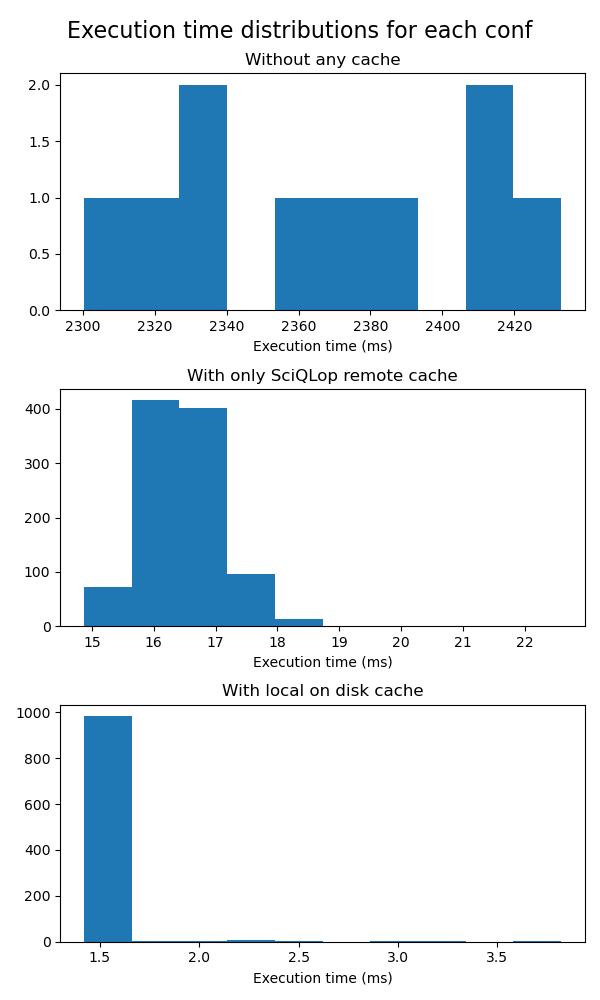

In [8]:
fig, axs = plt.subplots(3, 1, figsize=(6, 10))
for i,data,title in ((0,durations_without_any_cache,'Without any cache'),
                         (1,durations_with_remote_cache,'With only SciQLop remote cache'),
                         (2,durations_with_local_cache,'With local on disk cache') ):

    axs[i].hist(data)
    axs[i].set_xlabel('Execution time (ms)')
    axs[i].set_title(title)

fig.suptitle('Execution time distributions for each conf', fontsize=16)
plt.tight_layout()
plt.show()

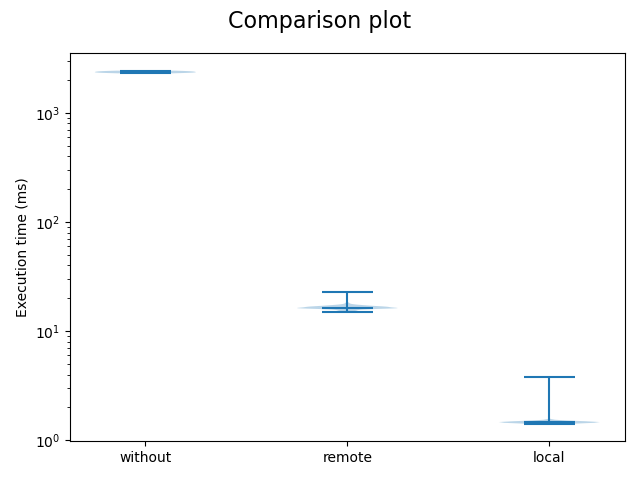

In [9]:
fig, ax = plt.subplots()
ax.violinplot([durations_without_any_cache, durations_with_remote_cache,durations_with_local_cache,], showmeans=False, showmedians=True)
ax.set_xticks([1,2,3],labels=['without', 'remote', 'local'])
ax.set_ylabel('Execution time (ms)')
plt.semilogy()
fig.suptitle('Comparison plot', fontsize=16)
plt.tight_layout()
plt.show()

## Scaling

### On disk cache scaling

In [13]:
start_time = datetime(2016,6,2)
def scaling_point(delta):
    stop_time=start_time+timedelta(hours=delta)
    data = spz.get_data(amda_tree.Parameters.ACE.MFI.ace_imf_all.imf, start_time, stop_time)
    capacity = data.data.nbytes
    t=times(spz.get_data, amda_tree.Parameters.ACE.MFI.ace_imf_all.imf, start_time, stop_time, n=20)
    return capacity,t

deltas=range(300,2000,80)
values = [scaling_point(delta) for delta in deltas]



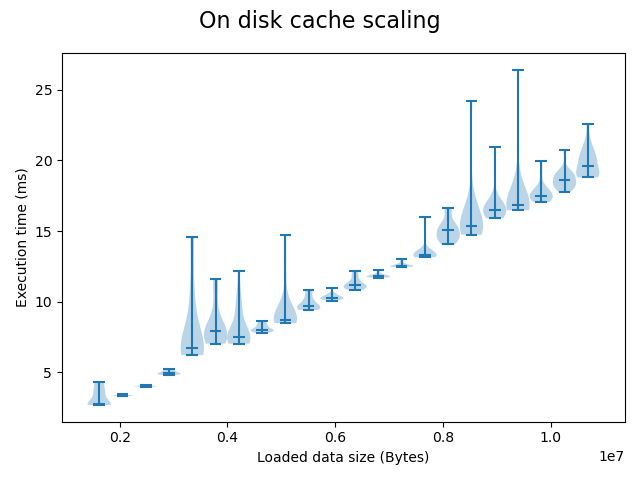

In [14]:
fig, ax = plt.subplots()
stats = [t for c,t in values]
capacities = np.array([c for c,t in values])
ax.violinplot(stats,positions=capacities,widths=np.gradient(capacities), showmeans=False, showmedians=True)
ax.set_ylabel('Execution time (ms)')
ax.set_xlabel('Loaded data size (Bytes)')
fig.suptitle('On disk cache scaling', fontsize=16)
plt.tight_layout()
plt.show()

### SciQLop remote cache scaling

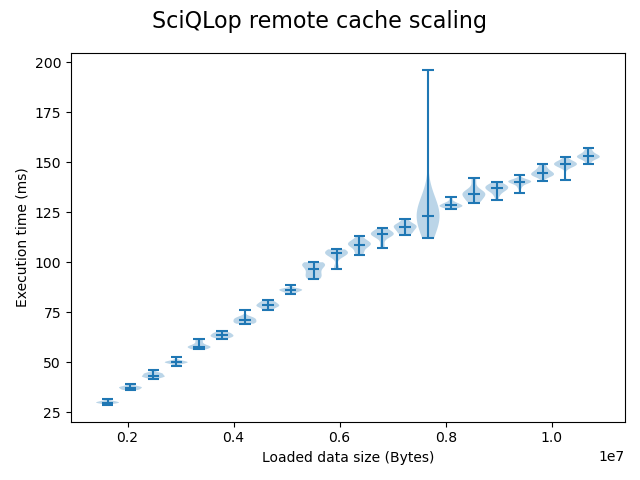

In [15]:
start_time = datetime(2016,6,2)
def scaling_point(delta):
    stop_time=start_time+timedelta(hours=delta)
    data = spz.get_data(amda_tree.Parameters.ACE.MFI.ace_imf_all.imf, start_time, stop_time, disable_cache=True)
    capacity = data.data.nbytes
    t=times(spz.get_data, amda_tree.Parameters.ACE.MFI.ace_imf_all.imf, start_time, stop_time, disable_cache=True, n=20)
    return capacity,t

deltas=range(300,2000,80)
values = [scaling_point(delta) for delta in deltas]


fig, ax = plt.subplots()
stats = [t for c,t in values]
capacities = np.array([c for c,t in values])
ax.violinplot(stats,positions=capacities,widths=np.gradient(capacities), showmeans=False, showmedians=True)
ax.set_ylabel('Execution time (ms)')
ax.set_xlabel('Loaded data size (Bytes)')
fig.suptitle('SciQLop remote cache scaling', fontsize=16)
plt.tight_layout()
plt.show()
